Task 1: Out of the Box Sentiment Analysis 

In [ ]:
# HIDE OUTPUT
!pip install transformers
!pip install transformers[sentencepiece]
!pip install datasets
!pip install google-cloud-translate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 26.8 MB/s 
     |████████████████████████████████| 7.6 MB 58.4 MB/s 
     |████████████████████████████████| 163 kB 65.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 35.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 38.0 MB/s 
     |████████████████████████████████| 212 kB 72.8 MB/s 
     |████████████████████████████████| 115 kB 71.2 MB/s 
     |████████████████████████████████| 95 kB 5.6 MB/s 
     |████████████████████████████████| 127 kB 70.6 MB/s 
     |████████████████████████████████| 115 kB 64.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Succes

In [ ]:
#Import libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

In [ ]:
#Preparing model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")


Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
classifier = pipeline("sentiment-analysis", model = model, tokenizer = tokenizer)

In [ ]:
with open('tiny_movie_reviews_dataset.txt', 'r') as f:
    reviews = f.readlines()
c = 0
for i in range(len(reviews)):
    inputs = reviews[i]
    output = classifier(inputs, max_length=512, truncation=True)
    if output[0]['label'] == 'LABEL_0':
        print("Review " + str(c) + ": " + "Negative")
    elif output[0]['label'] == 'LABEL_1':
        print("Review " + str(c) + ": " + "Neutral")
    elif output[0]['label'] == 'LABEL_2':
        print("Review " + str(c) + ": " + "Positive")
    c += 1


Review 0: Negative
Review 1: Positive
Review 2: Positive
Review 3: Negative
Review 4: Negative
Review 5: Positive
Review 6: Negative
Review 7: Positive
Review 8: Neutral
Review 9: Positive
Review 10: Positive
Review 11: Positive
Review 12: Neutral
Review 13: Negative
Review 14: Positive
Review 15: Positive
Review 16: Positive
Review 17: Neutral
Review 18: Positive
Review 19: Negative


Task 2: Take a basic, pretrained NER model, and train further on a task-specific dataset

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DefaultDataCollator
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
import keras
from matplotlib import pyplot as plt

In [ ]:
class ModelTrainer():
    def __init__(self, samples_data_test, samples_data_train):

      #samples of dataset
      self.samples_data_train = samples_data_train
      self.samples_data_test = samples_data_test

      #Loading dataset
      self.emotions = load_dataset("emotion")

      #Data collator
      self.data_collator = DefaultDataCollator(return_tensors="tf")

    def tokenize(self,rows):
      return self.tokenizer(rows['text'], padding="max_length", truncation=True)

    def split_dataset(self,data_set):
      self.small_train_dataset = data_set["train"].shuffle(seed=42).select([i for i in list(range(self.samples_data_train))])
      self.small_eval_dataset = data_set["test"].shuffle(seed=42).select([i for i in list(range(self.samples_data_test))])

    def tf_datasets(self):
      self.tf_train_dataset = self.small_train_dataset.to_tf_dataset(
          columns=["attention_mask", "input_ids"],
          label_cols=["labels"],
          shuffle=True,
          collate_fn=self.data_collator,
          batch_size=8,
      )

      self.tf_validation_dataset = self.small_eval_dataset.to_tf_dataset(
          columns=["attention_mask", "input_ids"],
          label_cols=["labels"],
          shuffle=False,
          collate_fn=self.data_collator,
          batch_size=8,
      )


    def train_model(self):
      self.model = TFAutoModelForSequenceClassification.from_pretrained(\
                                                                        "distilbert-base-uncased", num_labels=6)
      self.model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=tf.metrics.SparseCategoricalAccuracy(),
        )

      self.history = self.model.fit(self.tf_train_dataset, validation_data=self.tf_validation_dataset,epochs=5)
      return self.model
      
    
    def main(self):
      self.model_ckpt = "distilbert-base-uncased"
      self.tokenizer = AutoTokenizer.from_pretrained(self.model_ckpt)
      self.emotions.set_format(type=None)
      self.tokenized_datasets = self.emotions.map(self.tokenize, batched=True)
      self.split_dataset(self.tokenized_datasets)
      self.tf_datasets()
      self.modelh = self.train_model()

    def graphic_model(self):
      plt.plot(self.history.history['loss'])
      plt.plot(self.history.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'val'], loc='upper left')
      plt.show()

      plt.plot(self.history.history['sparse_categorical_accuracy'])
      plt.plot(self.history.history['val_sparse_categorical_accuracy'])
      plt.title('model accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train', 'val'], loc='upper left')
      plt.show()


       


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/5
375/375 [==============================] - 183s 460ms/step - loss: 0.7941 - sparse_categorical_accuracy: 0.7290 - val_loss: 0.3127 - val_sparse_categorical_accuracy: 0.8800
Epoch 2/5
375/375 [==============================] - 179s 477ms/step - loss: 0.2833 - sparse_categorical_accuracy: 0.9077 - val_loss: 0.3756 - val_sparse_categorical_accuracy: 0.8733
Epoch 3/5
375/375 [==============================] - 181s 484ms/step - loss: 0.1719 - sparse_categorical_accuracy: 0.9397 - val_loss: 0.2802 - val_sparse_categorical_accuracy: 0.8900
Epoch 4/5
375/375 [==============================] - 181s 483ms/step - loss: 0.1105 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.2818 - val_sparse_categorical_accuracy: 0.9167
Epoch 5/5
375/375 [==============================] - 181s 483ms/step - loss: 0.0745 - sparse_categorical_accuracy: 0.9743 - val_loss: 0.3747 - val_sparse_categorical_accuracy: 0.9033


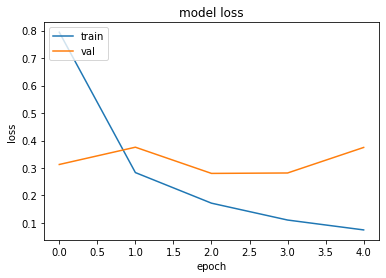

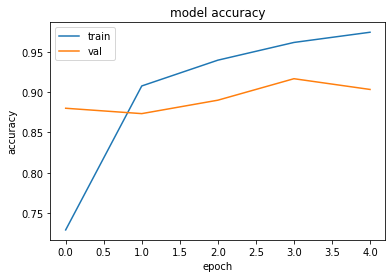

In [ ]:
if __name__ == '__main__':

	samples_train = 3000
	samples_test = 300
	model_trainer = ModelTrainer(samples_test, samples_train)
	model_trainer.main()
	model_trainer.graphic_model()

	

Task 3:Set up and compare model performance of two different translation models

In [86]:
from google.cloud import translate_v2
import requests, uuid, json
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import statistics


In [87]:
class translate_blue():
  def __init__(self, lang1_set, lang2_set, lang_from, lang_to, key_azure, region_azure, gcp_keys_json_name):
    self.lang1 = lang1_set
    self.lang2 = lang2_set
    self.lang_from = lang_from
    self.lang_to = lang_from
    self.cod_key = key_azure
    self.cod_region = region_azure
    self.gcp_keys_json_name = gcp_keys_json_name

  def azure_translate(self,text):
    # Add your key and endpoint
    endpoint = "https://api.cognitive.microsofttranslator.com"

    path = '/translate'
    constructed_url = endpoint + path

    params = {
        'api-version': '3.0',
        'from': self.lang_from,
        'to': self.lang_to
    }

    headers = {
        'Ocp-Apim-Subscription-Key': self.cod_key,
        # location required if you're using a multi-service or regional (not global) resource.
        'Ocp-Apim-Subscription-Region': self.cod_region,
        'Content-type': 'application/json',
        'X-ClientTraceId': str(uuid.uuid4())
    }

    # You can pass more than one object in body.
    body = [{
        'text': text
    }]

    request = requests.post(constructed_url, params=params, headers=headers, json=body)
    response = request.json()

    return response[0]["translations"][0]["text"]

  def gcp_translate(self,text):
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = self.gcp_keys_json_name
    client = translate_v2.Client()
    output = client.translate(text, self.lang_to)
    return output['translatedText']

  def main(self):
    points_gcp = []
    points_azure = []
    with open(self.lang1, 'r') as f:
      lang1 = f.readlines()

    with open(self.lang2, 'r') as f:
      lang2 = f.readlines()

    for i in range(len(lang1)):
      output_azure = self.azure_translate(lang1[i])
      #print(output_azure)
      blue_azure = sentence_bleu(lang2[i].split(), output_azure.split())
      points_azure.append(blue_azure)

      output_gcp = self.gcp_translate(lang1[i])
      #print(output_gcp)
      blue_gcp = sentence_bleu(lang2[i].split(), output_gcp.split())
      points_gcp.append(blue_azure)

    print("Blue Score GCP: " + str(statistics.mean(points_gcp)))
    print("Blue Score azure: " + str(statistics.mean(points_azure)))
     

In [88]:
if __name__ == '__main__':
  lang1_set = 'en_corpus.txt'
  lang2_set = 'es_corpus.txt'
  lang_from = 'en'
  lang_to = 'es'
  cod_key = 'AzureKey'
  cod_region = 'AzureRegion'
  gcp_keys = 'private_key.json'
  
  blue_score = translate_blue(lang1_set, lang2_set, lang_from, lang_to, cod_key, cod_region, gcp_keys)
  blue_score.main()
	


Blue Score GCP: 3.937050276125801e-232
Blue Score azure: 3.937050276125801e-232
